# App-ifying 'recovering data from images'

**See [the other notebook](Guessing_colourmaps.ipynb) for the grisly details and dead-ends.** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`
- `pillow`

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make an image

Make some fake data in the closed interval [0,1] and apply a colourmap.

In [2]:
from scipy import signal

In [3]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

In [294]:
cd ~/Dropbox/dev/rainbow/notebooks

/home/matt/Dropbox/dev/rainbow/notebooks


In [295]:
cmap = 'gist_ncar'

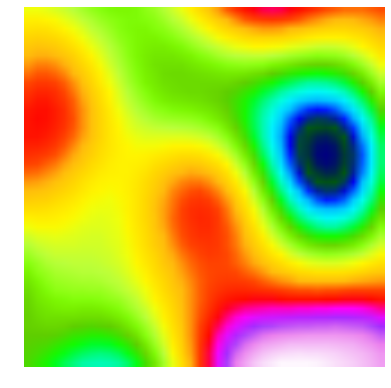

In [296]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Note: interpolation introduces new colours.
plt.imshow(z, cmap=cmap, aspect='auto')
#plt.imshow(z, cmap=cmap, interpolation='none')

fig.savefig('data/cbar/test.png')

In [297]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]

In [298]:
# fig, axes = plt.subplots(24, 6, figsize=(10, 7))
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
#                     hspace=0.1, wspace=0.1)

# im = np.outer(np.ones(10), np.arange(100))

# cmaps = [m for m in plt.cm.datad if not m.endswith("_r")]
# cmaps.sort()

# axes = axes.T.ravel()
# for ax in axes:
#     ax.axis('off')

# for cmap, color_ax, null_ax in zip(cmaps, axes[1::2], axes[2::2]):
#     del null_ax
#     color_ax.set_title(cmap, fontsize=10)
#     color_ax.imshow(im, cmap=cmap)

## Read an image

In [299]:
cd ~/Dropbox/dev/rainbow/notebooks

/home/matt/Dropbox/dev/rainbow/notebooks


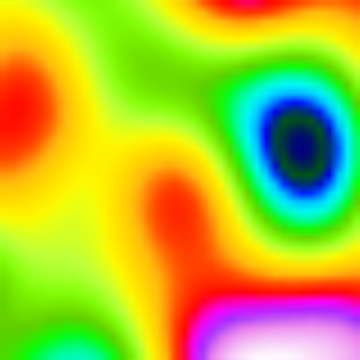

In [300]:
from PIL import Image

# img = Image.open('data/cbar/boxer.png')
# img = Image.open('data/cbar/fluid.png')
# img = Image.open('data/cbar/lisa.png')
# img = Image.open('data/cbar/redblu.png')
# img = Image.open('data/cbar/seismic.png')
# img = Image.open('data/cbar/drainage.jpg')
img = Image.open('data/cbar/test.png')

img

In [301]:
img.size

(360, 360)

Instead of taking a random sample, let's take all pixels from a smaller version of the image.

In [302]:
# def resize_if_necessary(img, max_size=256):
#     h, w = img.size
#     if h * w > max_size**2:
#         img = img.resize((max_size, max_size))
#     return img

In [303]:
# img_sm = resize_if_necessary(img)

Cast as an array, and ignore the last channel (alpha), if there is one.

## Quantize with scikit

In [364]:
n_colours = 128

In [365]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [366]:
im = np.asarray(img)[..., :3] / 255.

h, w, d = im.shape
im_ = im.reshape((w * h, d))

# Define training set.
n = min(h*w//50, n_colours*10)
sample = shuffle(im_, random_state=0)[:n]

In [367]:
print("Sampled {} pixels".format(n))

Sampled 1280 pixels


Train:

In [368]:
kmeans = KMeans(n_clusters=n_colours).fit(sample)

Now I can make an RGB palette `p` — also known as a codebook in information theory terms:

In [369]:
p = kmeans.cluster_centers_

# I don't know why I need to do this, but I do. Floating point precision maybe.
p[p > 1] = 1
p[p < 0] = 0

The only problem with this `p` is that it is not in order — that it, there cluster centres are more or less randomly arranged. We will fix that in the next section.

The vector `p` is actually all we need, but if you want to see what the quantized image looks like, carry on:

In [370]:
# labels = kmeans.predict(im_)

# def recreate_image(palette, labels, h, w):
#     image = np.zeros((h, w, palette.shape[1]))
#     label_idx = 0
#     for i in range(h):
#         for j in range(w):
#             image[i][j] = palette[labels[label_idx]]
#             label_idx += 1
#     return image

# q = recreate_image(p, labels, h, w)

# plt.imshow(q)
# plt.show()

## Travelling salesman problem

Remember that these points are essentially in random order:

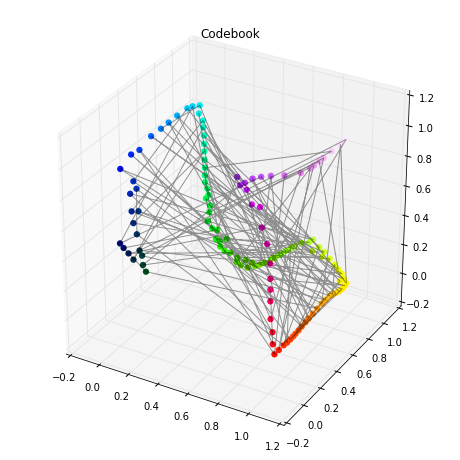

In [371]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.plot(*p.T, color='k', alpha=0.4)
ax.set_title('Codebook')

plt.show()

I propose starting at the dark end (the end of the line nearest black) and crawling aling the line of points from there. This will make a nice organized sequence of codes — in our case, this will be the colourmap.

We can solve this problem as the travelling salesman problem. Find the shortest tour from black to 'the other end'.

To start with, we need the distances between all points. This is just a norm, but there's a convenient function `scipy.spatial.pdist` for finding distance pairs in *n*-space. Then `squareform` casts it into a square symmetric matrix, which is what we need for our TSP solver.

Other than creating a naive TSP solver in Python – let's face it, it'll be broken or slow or non-optimal — there are three good TSP solver options:

* [LKH](http://www.akira.ruc.dk/~keld/research/LKH/) — [parameter help here](http://webhotel4.ruc.dk/~keld/research/LKH/LKH-2.0/DOC/LKH-2.0_PARAMETERS.pdf).
* [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html) (I followed [these instructions](http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt) for installing concorde on my Mac.)
* [O-R tools](https://developers.google.com/optimization/routing/tsp)

LKH and Concorde can be used via [the TSP Python package](https://github.com/perrygeo/pytsp) (but note that it used to be called `pyconcorde` so you need to change the names of some functions — look at the source or use [my fork](https://github.com/kwinkunks/pytsp).

Note that you need to add the Concorde and LKH libs to PATH as mentioned in the docs for `pytsp`.

In [372]:
from pytsp import run, dumps_matrix

We want to start the traversal of the locus at the end nearest black. This is a heuristic based on the observation that we tend to map darker colours to lower values. Adding this point allows us to start the TSP there, because it will move to the next nearest point — I think. We will remove it later.

Add black point to `p`:

In [373]:
p = np.vstack([[[0,0,0]], p])

In [374]:
p[:6]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.09150327e-01,   5.17647059e-01,   9.38562092e-01],
       [  4.99159664e-01,   9.36694678e-01,   4.20168067e-02],
       [  1.00000000e+00,   5.22408964e-01,   2.74509804e-02],
       [  1.11022302e-16,   9.65826331e-01,   8.31932773e-01],
       [  0.00000000e+00,   1.57843137e-01,   6.07843137e-01]])

Remember that these points are essentially in random order. We are going to solve the find the shortest Hamiltonian path to organize them.

To do this, we need weights for the edges — and we'll use the distances between the points. There's a convenient function, `scipy.spatial.pdist` for finding distances in *n*-space. We will use the 2-norm, but [the `pdist` function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) has a great many other metrics.

The convenience function `squareform` organizes the distances into a matrix.

In [375]:
from scipy.spatial.distance import pdist, squareform

# Make distance matrix.
dists = squareform(pdist(p, 'euclidean'))

# The values in `dists` are floats in the range 0 to sqrt(3). 
# Normalize the values to int16s.
d = 32767 * dists / np.sqrt(3)
d = d.astype(np.int16)

# To use a TSP algo to solve the shortest Hamiltonian path problem,
# we need to add a point that is zero units from every other point.
row, col = d.shape
d = np.insert(d, row, 0, axis=0)
d = np.insert(d, col, 0, axis=1)

The zero-point trick is legit. [Reference](http://stackoverflow.com/questions/6733999/what-is-the-problem-name-for-traveling-salesman-problemtsp-without-considering) from E. L. Lawler, Jan Karel Lenstra, A. H. G. Rinnooy Kan, D. B. Shmoys (1985). The Traveling Salesman Problem: A Guided Tour of Combinatorial Optimization, 1st Edition. Wiley. 476 pp. ISBN 978-0471904137.

In [376]:
d

array([[    0, 26589, 20095, ..., 17988, 24352,     0],
       [26589,     0, 20265, ..., 23833, 18822,     0],
       [20095, 20265,     0, ...,  7040, 18787,     0],
       ..., 
       [17988, 23833,  7040, ...,     0, 16340,     0],
       [24352, 18822, 18787, ..., 16340,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int16)

LKH implementation.

K. Helsgaun (2009). General k-opt submoves for the Lin-Kernighan TSP heuristic. Mathematical Programming Computation, 2009, doi: 10.1007/s12532-009-0004-6.

In [377]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [378]:
tour_lkh = run(outf, start=0, solver="LKH")

In [379]:
#result = np.array(tour_concorde['tour'])
result = np.array(tour_lkh['tour'])

In [380]:
result

array([  0,  71,  10,  94,  47,  80,  90,  72,  26,  39,  78, 108,   5,
        66,  38, 119,  92,  53,  21,  76,  50,  13,  62, 118,  25,  49,
       128,   4,  81,  42, 116,  79,  12,  99,  35, 122,  68,  24, 103,
       123,  15,  52, 104,  73, 107, 127,   8, 109,  64,  31, 125,  44,
        98,  69,  20, 120, 124,  56,  48,  43,   2, 102,  58, 110,  23,
        84,  51,  75,   9,  67,  77,  41,  91, 126,  32, 112,  17, 121,
        59,  28,  55, 115,   6,  61,  34, 111,  19,  93,  30,  70,   3,
        82,  37,  63, 113,  33, 114,   7,  85,  40,  96,  22, 106,  65,
        45,  14, 105,  54,  88,  36,  89,  18,  60,  86,  11, 117,  74,
        83,  27,  57, 101,   1,  97,  46,  16,  95, 100,  29,  87, 129])

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offsets are to account for the fact that we added a black point at the start and a zero point at the end.

In [381]:
c = p[result[1:-1]]

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

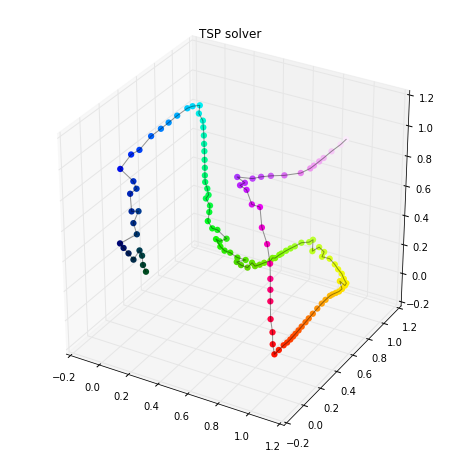

In [382]:
from mpl_toolkits.mplot3d import Axes3D
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.set_title('TSP solver')

plt.show()

Check below an interactive version of the 3D plot. May help when there are complicated paths between points. You need to install plotly and colorlover (with pip) if you don't already have them.

In [383]:
import plotly.graph_objs as go
import colorlover as cl
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

cb = cl.to_rgb(tuple(map(tuple, c*255)))
trace = go.Scatter3d(
        name='TSP Sover',
        x = c[:,0], y = c[:,1], z = c[:,2],
        marker = dict(
            size=4.,
            color=cb
        ),
        line=dict(
            color='#000',
            width=1,
        ),
        )
data = [trace]

# Set the different layout properties of the figure:
layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin = dict(
        t=0,b=0,l=0,r=0
    ),
    scene = go.Scene(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectmode='cube',
        camera=dict( 
            eye=dict(
                x=1.7,
                y=-1.7,
                z=1,
            )
        ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [384]:
from scipy.spatial import cKDTree

kdtree = cKDTree(c)

In [385]:
dx, ix = kdtree.query(im)

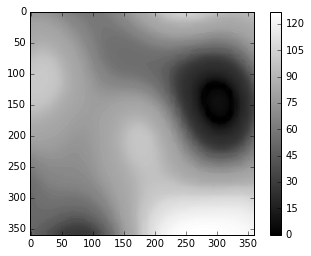

In [386]:
plt.imshow(ix, cmap='gray')
plt.colorbar()
plt.show()

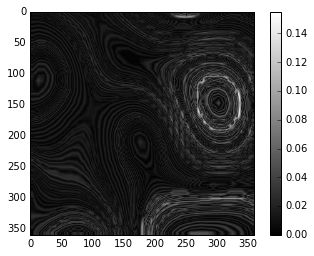

In [387]:
plt.imshow(dx, cmap='gray')
plt.colorbar()
plt.show()

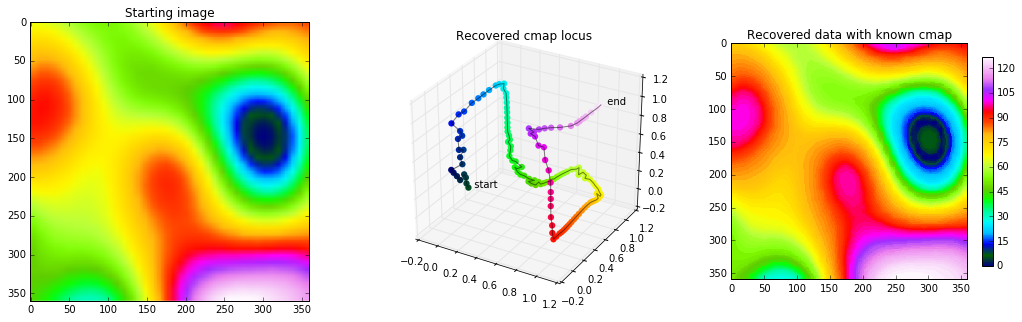

In [388]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], '  start')
ax1.text(*c[-1], '  end')
ax1.set_title("Recovered cmap locus")

ax2 = fig.add_subplot(133)
plt.imshow(ix, cmap=cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax2.set_title("Recovered data with known cmap")

plt.show()

In [389]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]

## Recover the colourbar

In [390]:
# setting up color arrays
r1 = np.array(c)[:, 0] # value of Red for the nth sample
g1 = np.array(c)[:, 1] # value of Green for the nth sample
b1 = np.array(c)[:, 2] # value of Blue for the nth sample

r2 = r1 # value of Red at the nth sample
r0 = np.linspace(0, 1, len(r1)) # position of the nth Red sample within the range 0 to 1

g2 = g1 # value of Green at the nth sample
g0 = np.linspace(0, 1, len(g1)) # position of the nth Green sample within the range 0 to 1

b2 = b1 # value of Blue at the nth sample
b0 = np.linspace(0, 1, len(b1)) # position of the nth Blue sample within the range 0 to 1

# creating lists
R = zip(r0, r1, r2)
G = zip(g0, g1, g2)
B = zip(b0, b1, b2)

# creating list of above lists and transposing
RGB = zip(R, G, B)
rgb = zip(*RGB)
#print rgb

# creating dictionary
k = ['red', 'green', 'blue'] # makes list of keys
data_dict = dict(zip(k,rgb)) # makes a dictionary from list of keys and list of values

# Make a colourbar
import matplotlib.colors as clr

found_cmap = clr.LinearSegmentedColormap('my_colourmap', data_dict)

If we render the found data with the found colorbar, it will look perfect, because the colourbar is the codebook that maps the data to the original image.

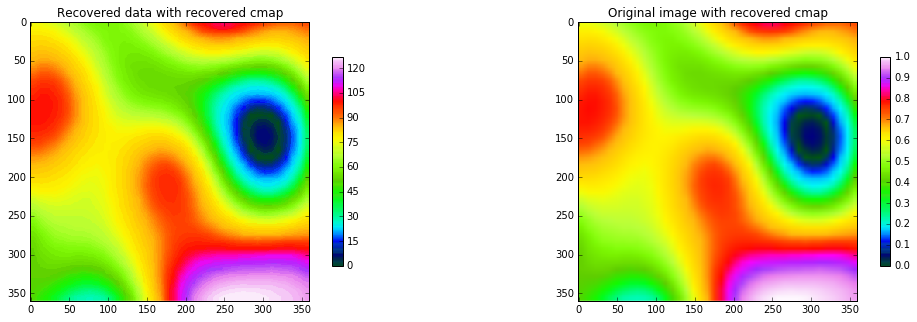

In [402]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(121)
plt.imshow(ix, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax0.set_title("Recovered data with recovered cmap")

ax1 = fig.add_subplot(122)
plt.imshow(im, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax1.set_title("Original image with recovered cmap")

plt.show()

## Compare the result to what we started with

This only makes sense for the synthetic data, not the test images.

Scale to [0,1] and compare to `z`.

In [391]:
z_out = ix.astype(np.float)
z_out /= np.amax(z_out)

In [392]:
z.shape, z_out.shape

((40, 40), (360, 360))

The original data, `z`, is a different shape. At the risk of distorting it, let's resize it.

In [393]:
from scipy.misc import imresize

z_ = imresize(z, z_out.shape) / 255

In [394]:
diff = z_ - z_out

In [395]:
def rms(a):
    return np.sqrt(np.sum(a**2)/a.size)

print("RMS difference: {:.4f}".format(rms(diff)))

RMS difference: 0.0543


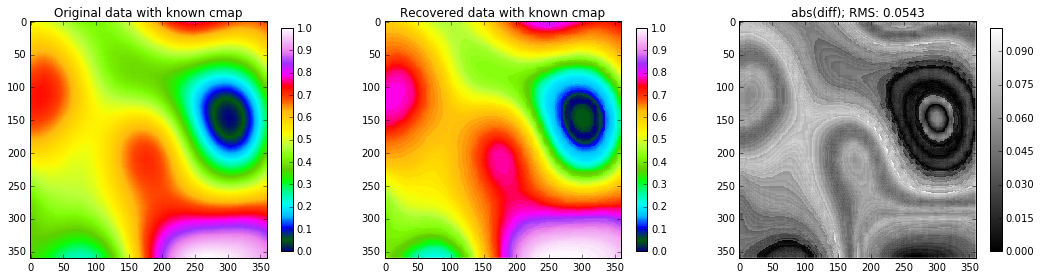

In [403]:
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131)
plt.imshow(z_, cmap=cmap)
plt.colorbar(shrink=0.8)
ax1.set_title("Original data with known cmap")

ax2 = fig.add_subplot(132)
plt.imshow(z_out, cmap=cmap, interpolation='none')
plt.colorbar(shrink=0.8)
ax2.set_title("Recovered data with known cmap")

ax3 = fig.add_subplot(133)
plt.imshow(abs(diff), interpolation='none', cmap='gray')
plt.colorbar(shrink=0.8)
ax3.set_title("abs(diff); RMS: {:.4f}".format(rms(diff)))

plt.show()